#### Imports

In [1]:
import src.web_scraping.downloading_metrics as downloading
from src.web_scraping.downloading_countries import save_countries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import seaborn as sns
import src.visualisations.plotting_utilis as my_plt
import src.data_preprocessing.utils as preprocess_utils
from ydata_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

DOWNLOAD COUNTRIES


### Problem Statement

What are the factors influencing the median age of a country's population?
Currently, in most of the developed, as well as in the developing countries, there has been observed the phenomenon of ageing population. The main observed factors are:
1. Increase of mean and median ages
2. Decline in proportion of children and increase in proportion of elderly

Considering various metrics of country like demographic data, education and finances, we'll try to fit different regression models for median age. We'll discover how those metrics influence, and if at all, the median age.

### How Data Is Acquired

Data is scraped from website https://www.cia.gov/the-world-factbook where each country has it's own value for a given metric. Change 'download' to True to download data

In [2]:
download = False

if download:
    metrics = downloading.CATEGORICAL_METRICS + downloading.NUMERICAL_METRICS
    downloading.download_metrics(metrics)

#### Overwiew of the metrics

Below are definitions for the candidate metrics: 
1. Infant mortality rate
2. Population growth rate
3. Alcohol consumption
4. Tobbaco use
5. Child marriage: woman by 18 and men by 18
6. Currently married women ages 15-49
7. Birth rate
8. Life expectancy
9. Death rate
10. Labor force by occupation: agriculture, services and industry
11. Contraceptive prevalence rate
12. Maternal mortality ratio - number / 100,000 births of women who dies in cause of pregnancy or short after
13. Mothers mean age at first birth
14. Health expenditures
15. Gdp per capita
16. Literacy 
17. Physicians density - number of medical doctors per 1,000 of the population 
18. Education expenditures
19. Population below poverty 
20. Population size 
21. Continent

Some of them may be dependent on each other, and some may be irrelevant to the analysis of the median age. In the following section the most suitable suite of metrics will be chosen. 

### Explanatory Data Analysis

First, we'll explore the predictor 

##### Median Age 

In [3]:
median_age = downloading.open_metric('median age')['total']

In [4]:
nan_index = median_age[median_age.isna()].index
print("Countries with missing median age: ", list(nan_index))
median_age = median_age.drop(nan_index)
countries = median_age.index

Countries with missing median age:  ['Holy See']


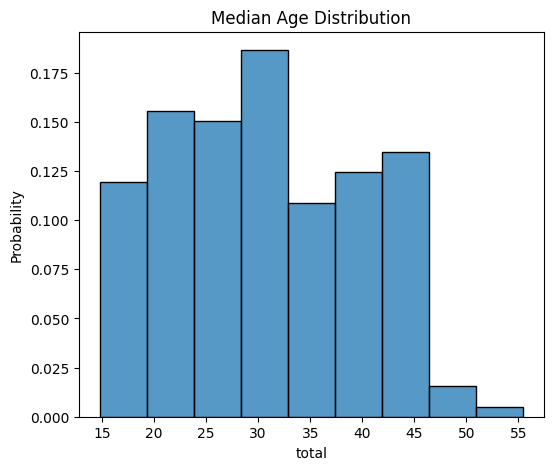

In [5]:
plt.figure(figsize=(6, 5))
sns.histplot(data=median_age, stat='probability')
_ = plt.title('Median Age Distribution')

In [6]:
median_age.describe()

count    193.000000
mean      30.574611
std        9.102480
min       14.800000
25%       23.500000
50%       29.800000
75%       38.400000
max       55.400000
Name: total, dtype: float64

##### Fitting median age to distribution
Is the data normal? + use Parzen estimator

##### Median Age By Region

Next, we'll see whether median age depends on the continent

In [7]:
country_continents = preprocess_utils.assign_continents(median_age.index)
continents = list(np.unique(country_continents.values))
country_continents.value_counts()

continent    
Africa           53
Asia             47
Europe           44
North America    23
Oceania          14
South America    12
dtype: int64

In [8]:
np.flatnonzero(country_continents['continent'] == 'Africa')

array([  2,   4,  17,  21,  25,  27,  28,  30,  32,  33,  37,  39,  44,
        46,  50,  52,  53,  55,  56,  61,  64,  68,  69,  86,  94,  95,
        96, 100, 101, 104, 107, 108, 114, 115, 116, 122, 123, 138, 141,
       147, 149, 151, 152, 157, 159, 162, 168, 171, 173, 176, 180, 191,
       192], dtype=int64)

As expected, the median age distribution depends on the continent. For example, in Europe we can see the phenomenon of population-ageing, and for Africa the prevalence of youth & children lowers the median age.

<Figure size 700x700 with 0 Axes>

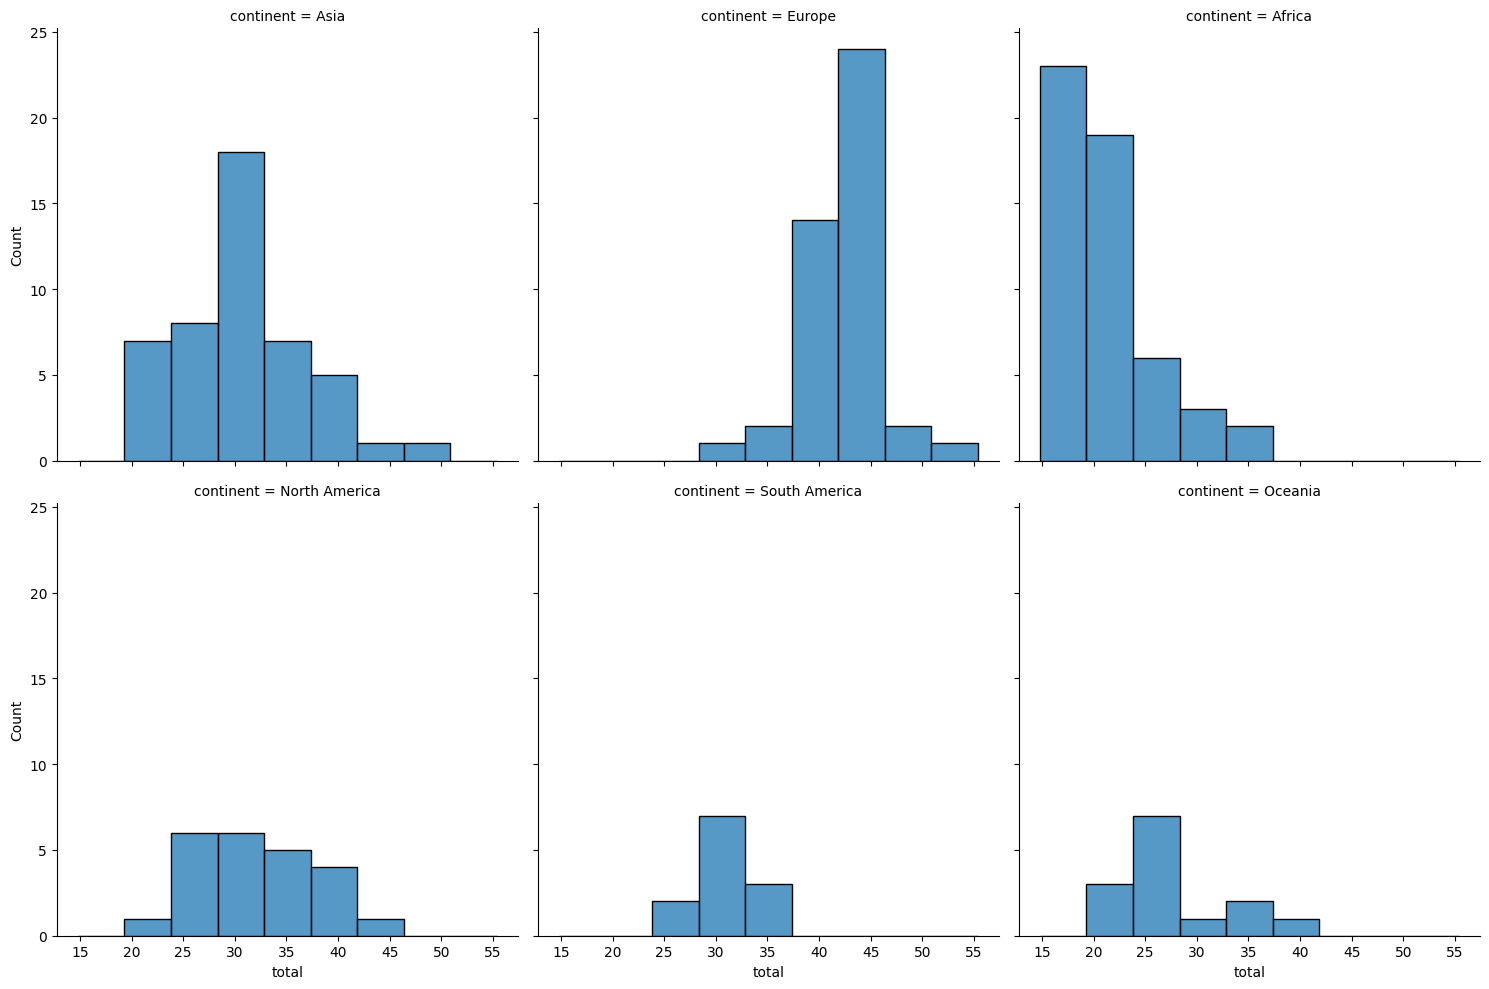

In [9]:
plt.figure('Median Age Distribution By Regions', figsize=(7, 7))
median_age_and_continent = pd.concat([median_age.to_frame(), country_continents['continent']], axis=1)
sns.displot(data=median_age_and_continent, x='total', kind='hist', col='continent', col_wrap=3)

##### Scatterplots

Next, we'll visually analyze relationship of median age with different numerical metrics and the distributions of those metrics.



In [10]:
country_metrics = preprocess_utils.merge_metrics(median_age.index)
print(country_metrics.describe().transpose()[['count', 'mean', 'std']])

                                    count          mean           std
infant mortality rate               193.0  2.118456e+01  1.917384e+01
population growth rate              193.0  1.058238e+00  1.123748e+00
alcohol consumption per capita      186.0  4.702581e+00  3.686874e+00
tobacco use total                   162.0  2.033272e+01  9.856951e+00
women marriage by 18                 73.0  2.228630e+01  1.396726e+01
men marriage by 18                   52.0  4.765385e+00  4.672694e+00
currently married women ages 15-49  190.0  5.783684e+01  8.646026e+00
birth rate                          193.0  1.834228e+01  9.156810e+00
life expectancy                     193.0  7.402731e+01  6.861937e+00
death rate                          193.0  7.529223e+00  2.675843e+00
agriculture occupation ratio        177.0  2.919356e+01  2.731340e+01
industry occupation ratio           174.0  1.935000e+01  9.413431e+00
services occupation ratio           162.0  5.469420e+01  2.067457e+01
contraceptive preval

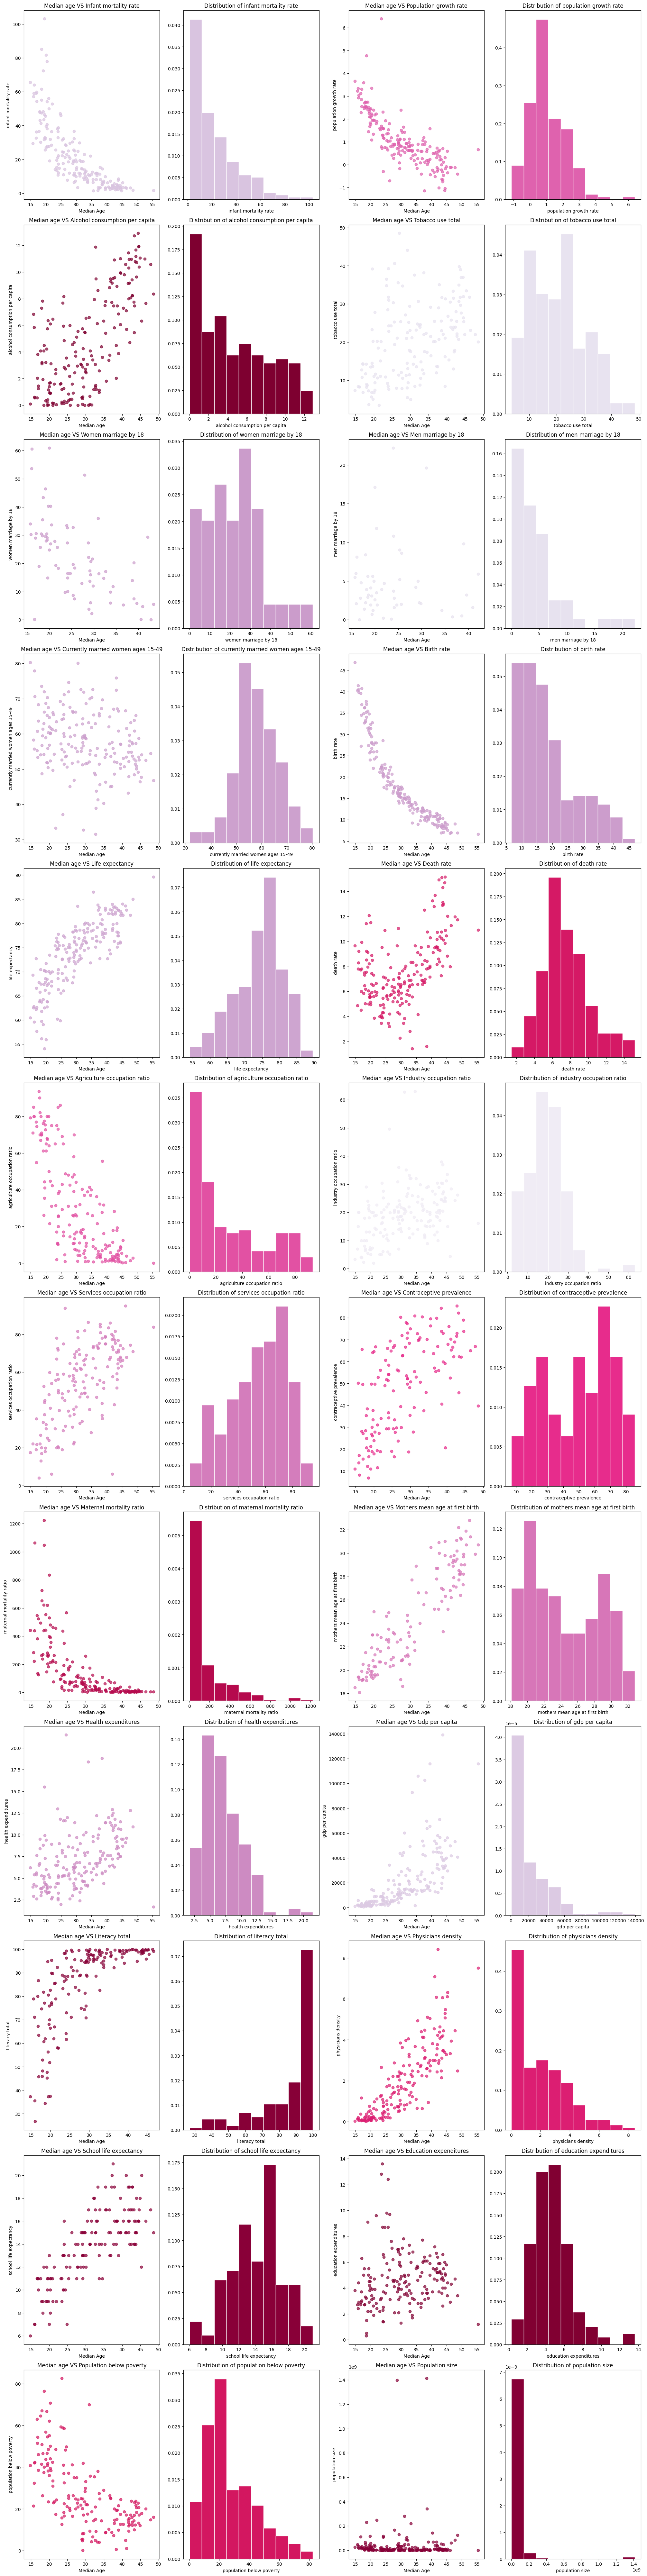

In [11]:
my_plt.create_grid_dist_and_scatter_plots(median_age, country_metrics, country_metrics.columns)

In [12]:
# profile = ProfileRepbort(country_metrics)
# profile.to_file('my_report.html')
# profile

Popution metric is highly skewed, so we'll apply logartihmic transformation to see the data better

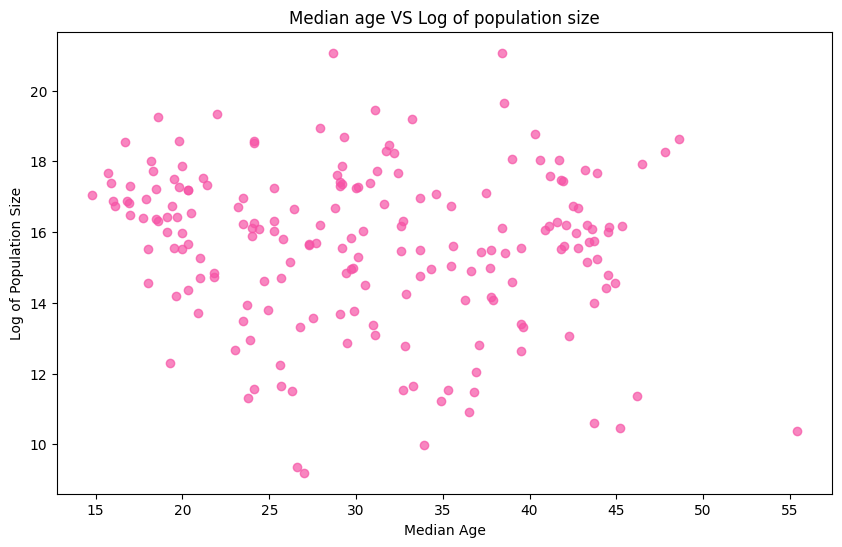

In [13]:
logarithm_transformation = lambda s: np.log(s, where=s > 0)

fig, ax = plt.subplots(figsize=(10, 6))

my_plt.plot_x_vs_y(median_age, logarithm_transformation(country_metrics['population size']), 
                   'Median Age', 'Log of Population Size', ax)

Because 'gdp per capita' is better on logarithmic scale, we'll use that one

In [14]:
# country_metrics['log of gdp per capita'] = logarithm_transformation(country_metrics['gdp per capita'])
# country_metrics.drop(['gdp per capita'], axis=1, inplace=True)

#### Introductory Feature Selection

Because there are a lot of candidate metrics and we don't want to make the model very complex, metrics which have a lot of missing values & metrics which doesn't seem to vary with the median age. 

In [15]:
dropped_columns = preprocess_utils.drop_columns_with_percent_of_nulls(country_metrics)
dropped_columns

Index(['women marriage by 18', 'men marriage by 18'], dtype='object')

Pearson correlation coefficient measures the linear relationship between variables

In [16]:
pearson_corr_with_median_age = country_metrics.corrwith(median_age, method='pearson')
abs_pearson_corr_with_median_age = pearson_corr_with_median_age.apply(lambda x: abs(x))
print(pearson_corr_with_median_age.sort_values(key=lambda x: abs(x)))

population size                       0.019296
education expenditures                0.092089
currently married women ages 15-49   -0.272118
industry occupation ratio             0.378867
health expenditures                   0.405801
tobacco use total                     0.450943
death rate                            0.499398
contraceptive prevalence              0.616902
services occupation ratio             0.637108
population below poverty             -0.646274
maternal mortality ratio             -0.673977
gdp per capita                        0.680552
alcohol consumption per capita        0.694585
literacy total                        0.699223
school life expectancy                0.759234
agriculture occupation ratio         -0.761699
population growth rate               -0.786838
infant mortality rate                -0.796495
life expectancy                       0.816318
physicians density                    0.831301
mothers mean age at first birth       0.901760
birth rate   

We'll drop features which don't represent any pattern

In [17]:
features_to_drop = ['currently married women ages 15-49', 
                    'contraceptive prevalence', 'tobacco use total', 
                    'taxes and other revenues', 'population size', 
                    'industry occupation ratio', 
                    'education expenditures']

country_metrics.drop(features_to_drop, axis=1, inplace=True, errors='ignore')

Spearman's rank correlation coefficient is a nonparametric measure of rank correlation - statistical dependence between the rankings of two variables. It assesses how well the relationship between two variables can be described using monotonic function. Mathematically, it is roughly the same as pearson correlation coefficient between ranking of values. 



In [18]:
spearman_corr_with_median_age = country_metrics.corrwith(median_age, method='spearman')
print(spearman_corr_with_median_age.sort_values(key=lambda x: abs(x)))

death rate                         0.472916
health expenditures                0.487052
services occupation ratio          0.633004
alcohol consumption per capita     0.650629
population below poverty          -0.678951
school life expectancy             0.759809
agriculture occupation ratio      -0.770108
literacy total                     0.807192
life expectancy                    0.833837
population growth rate            -0.847044
gdp per capita                     0.852807
maternal mortality ratio          -0.872187
physicians density                 0.875370
mothers mean age at first birth    0.883191
infant mortality rate             -0.898784
birth rate                        -0.979925
dtype: float64


##### Relationships between features

For now, all features were considered separately from others, but we should deal with the ones that are dependent on another. 

In [19]:
spearman_correlation_matrix = country_metrics.corr(method='spearman')
spearman_correlation_matrix

,infant mortality rate,population growth rate,alcohol consumption per capita,birth rate,life expectancy,death rate,agriculture occupation ratio,services occupation ratio,maternal mortality ratio,mothers mean age at first birth,health expenditures,gdp per capita,literacy total,physicians density,school life expectancy,population below poverty
infant mortality rate,1.000000,0.727495,-0.598094,0.884187,-0.906103,-0.272413,0.806086,-0.668719,0.892348,-0.851928,-0.496390,-0.864982,-0.751617,-0.838275,-0.814341,0.651557
population growth rate,0.727495,1.000000,-0.531571,0.864524,-0.603761,-0.489323,0.567117,-0.462118,0.708205,-0.693607,-0.474451,-0.607613,-0.757963,-0.732790,-0.566132,0.578520
alcohol consumption per capita,-0.598094,-0.531571,1.000000,-0.620472,0.481475,0.559444,-0.516518,0.469731,-0.525132,0.633421,0.443914,0.564024,0.502090,0.564039,0.582690,-0.341241
birth rate,0.884187,0.864524,-0.620472,1.000000,-0.812693,-0.436383,0.739343,-0.598330,0.861289,-0.850867,-0.445419,-0.829779,-0.788574,-0.852069,-0.723660,0.675151
life expectancy,-0.906103,-0.603761,0.481475,-0.812693,1.000000,0.063176,-0.789711,0.621547,-0.847320,0.858875,0.459266,0.852524,0.672925,0.779154,0.778204,-0.642459
death rate,-0.272413,-0.489323,0.559444,-0.436383,0.063176,1.000000,-0.233896,0.270083,-0.232733,0.422810,0.349707,0.231104,0.239435,0.373217,0.254514,-0.186853
agriculture occupation ratio,0.806086,0.567117,-0.516518,0.739343,-0.789711,-0.233896,1.000000,-0.848838,0.777053,-0.822907,-0.533646,-0.852392,-0.668245,-0.771352,-0.754314,0.514056
services occupation ratio,-0.668719,-0.462118,0.469731,-0.598330,0.621547,0.270083,-0.848838,1.000000,-0.665649,0.737549,0.536234,0.671503,0.594246,0.707353,0.652405,-0.314824
maternal mortality ratio,0.892348,0.708205,-0.525132,0.861289,-0.847320,-0.232733,0.777053,-0.665649,1.000000,-0.844220,-0.499935,-0.859471,-0.788200,-0.860619,-0.773321,0.662537
mothers mean age at first birth,-0.851928,-0.693607,0.633421,-0.850867,0.858875,0.422810,-0.822907,0.737549,-0.844220,1.000000,0.574865,0.863852,0.746859,0.813093,0.826540,-0.702873


Correlation matrix will help us spot relationships between features so we can further remove them

<Axes: >

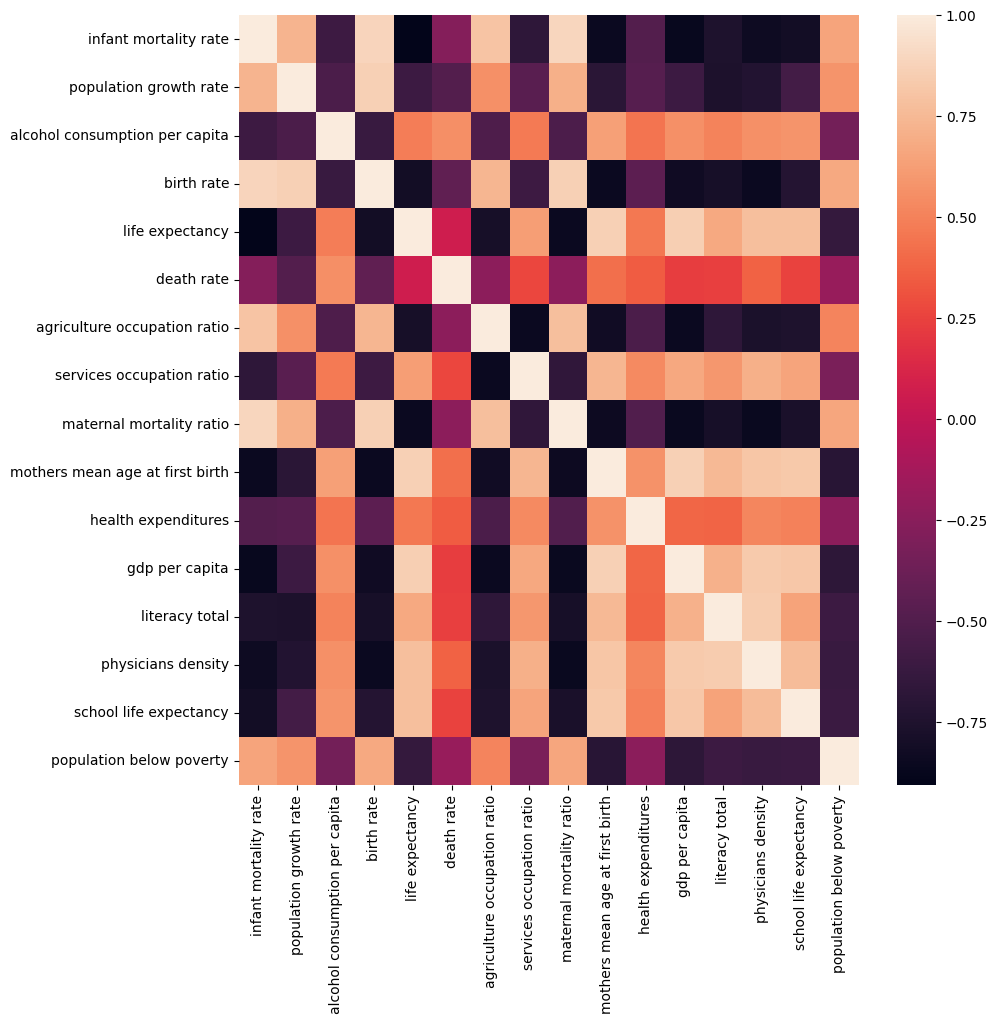

In [20]:
plt.figure(figsize=(10, 10))
sns.heatmap(spearman_correlation_matrix)

Correlation doesn't mean causation, but some metrics are naturally related to others. 
Firstly, occupation ratio in services is related to the one in agriculture. 

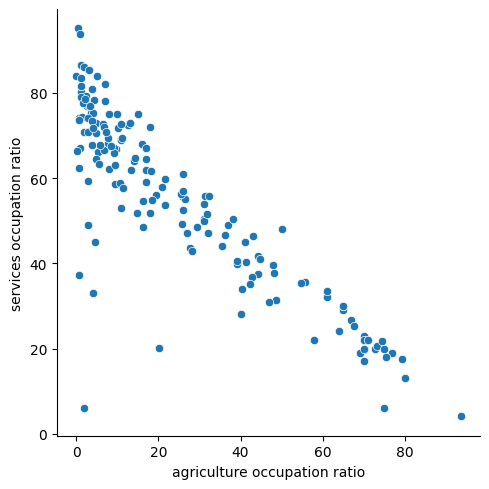

In [21]:
sns.relplot(data=country_metrics, x='agriculture occupation ratio', y='services occupation ratio')
country_metrics.drop(['agriculture occupation ratio'], axis=1, inplace=True)

Some metrics strongly depend on the birth rate. High birth rates are typically associated with low healthcare, hence there are higher values for 'maternal mortality ratio' and lower values for 'physicians density' (that is, the number of medical doctors per 1000 and they are the indicator of how well the primary needs can be met). 
Birth rates also determine population growth rate, and since high rates are typical for poor countries without the access to decent healthcare, it causes high infant mortality rate. Lower birth rates are typical for developed countries with access to healthcare, where the phenomenon of population ageing is observed. 

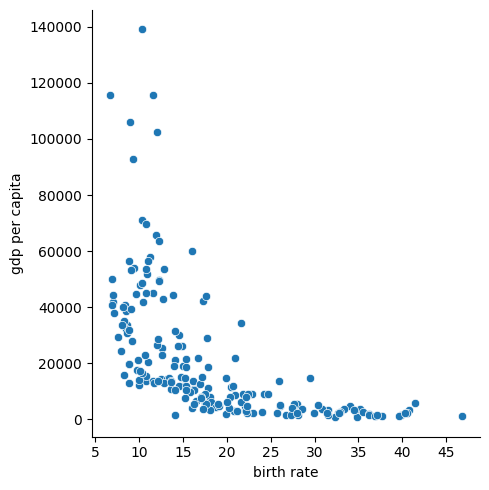

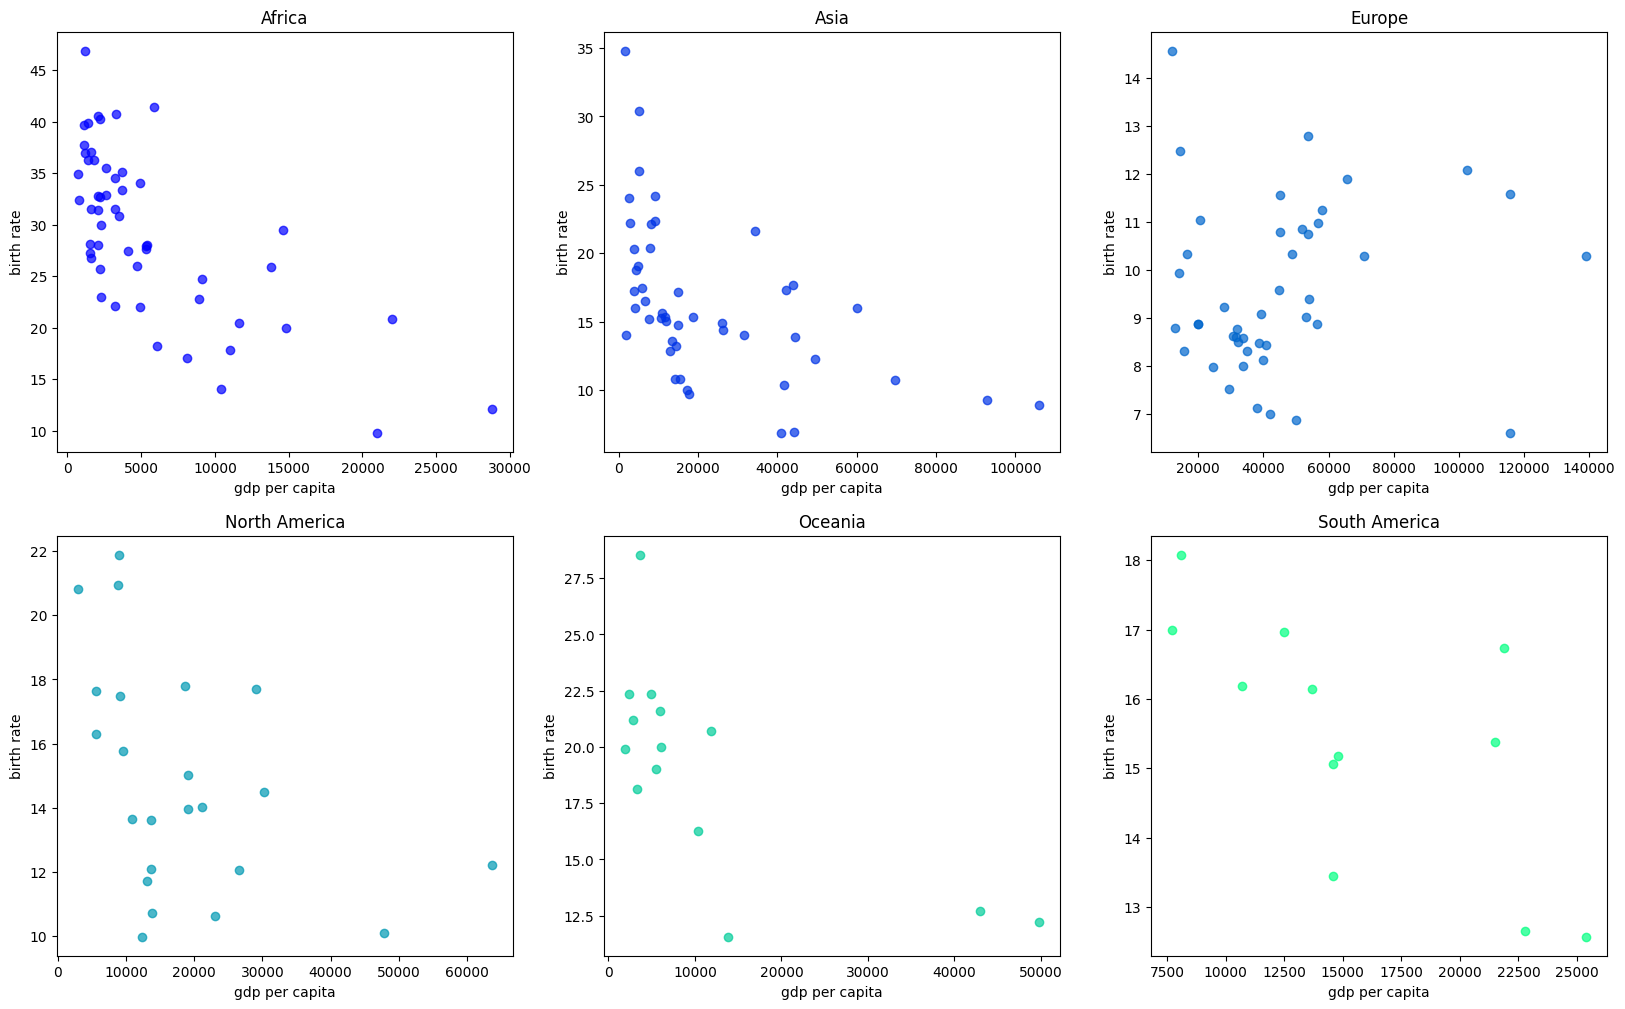

In [22]:
sns.relplot(data=country_metrics, x='birth rate', y='gdp per capita')
my_plt.plot_by_continent(country_metrics['gdp per capita'], 
                         country_metrics['birth rate'], 
                         country_continents['continent'], 'gdp per capita', 
                         'birth rate')

In [23]:
features = spearman_correlation_matrix['birth rate'].drop(['birth rate'])
features_dependent_on_birth_rate = features[np.abs(features) > 0.85] 
features_dependent_on_birth_rate

infant mortality rate              0.884187
population growth rate             0.864524
maternal mortality ratio           0.861289
mothers mean age at first birth   -0.850867
physicians density                -0.852069
Name: birth rate, dtype: float64

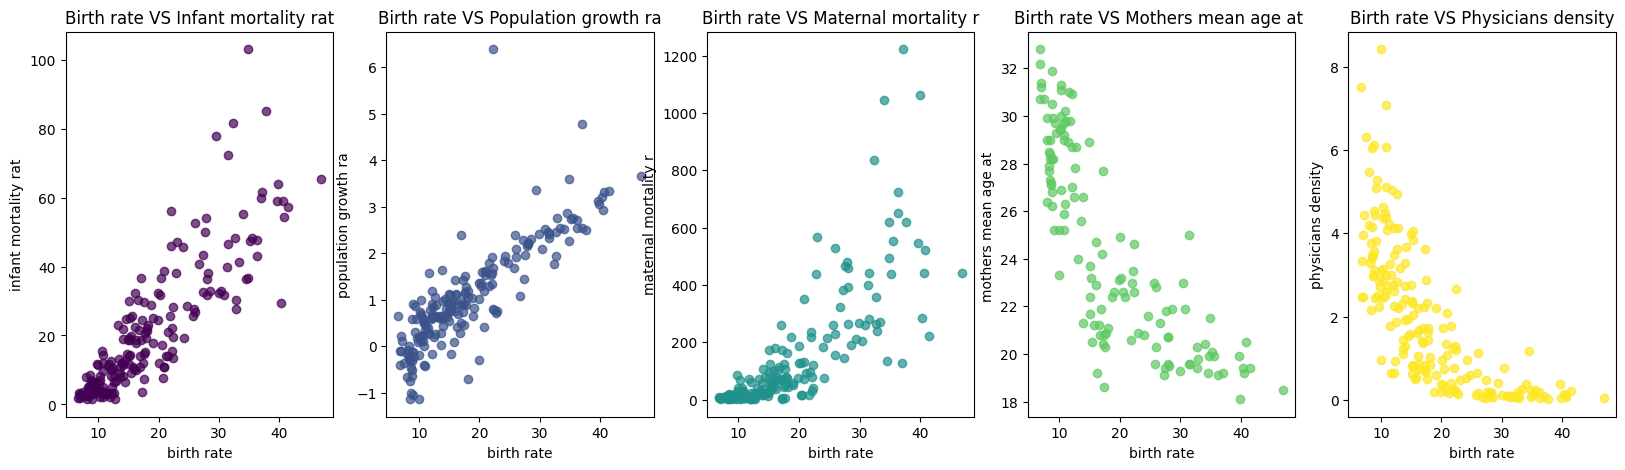

In [24]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

axes = axes.flatten()

cmap = colormaps['viridis'](np.linspace(0, 1, len(features_dependent_on_birth_rate)))
for i, feature in enumerate(features_dependent_on_birth_rate.index):
    my_plt.plot_x_vs_y(country_metrics['birth rate'], country_metrics[feature], 
                       'birth rate', feature[:20], ax=axes[i], color=cmap[i])
    

country_metrics.drop(features_dependent_on_birth_rate.index, axis=1, inplace=True)

In [25]:
country_metrics.head()

,alcohol consumption per capita,birth rate,life expectancy,death rate,services occupation ratio,health expenditures,gdp per capita,literacy total,school life expectancy,population below poverty
country,,,,,,,,,,
Afghanistan,0.01,34.79,54.05,12.08,37.6,15.5,1500.0,37.3,10.0,54.5
Albania,4.40,12.48,79.70,7.36,40.3,6.7,14500.0,98.4,14.0,14.3
Algeria,0.59,17.84,78.27,4.33,58.4,6.3,11000.0,81.4,NaN,5.5
Andorra,10.99,6.87,83.61,7.98,95.1,9.1,49900.0,100.0,NaN,NaN
Angola,5.84,41.42,62.51,7.80,NaN,2.9,5900.0,71.1,NaN,32.3


<Axes: >

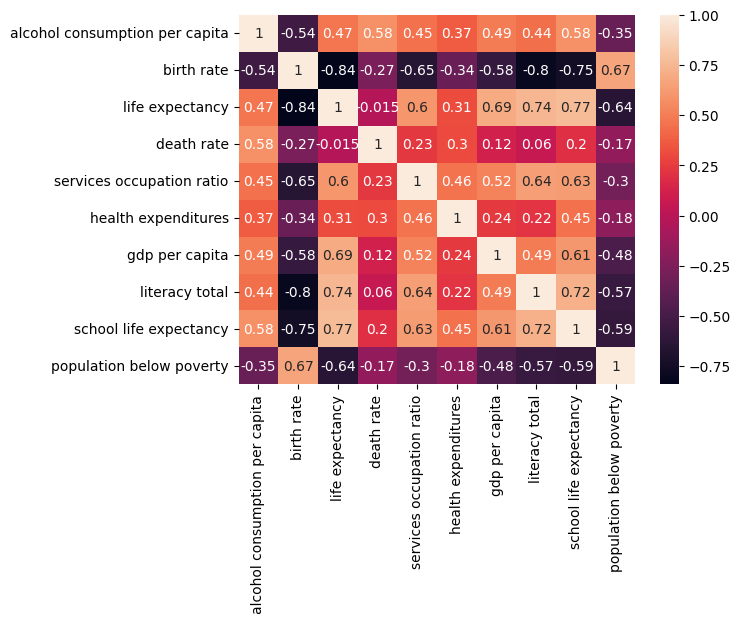

In [26]:
sns.heatmap(country_metrics.corr(), annot=True)

#### Data preprocessing

There are a few tasks we're going to work on there:
1. Missing values
2. Standardization

Missing values will be replaced with the mean for a given column. Next, values will be standardized using standard scaling. Linear regression doesn't really need that, but we'll use it so that other models (like SVR) can work correctly. 

Continent metric needs to be one-hot encoded

In [27]:
num_attribs = ['alcohol consumption per capita', 'birth rate',
               'life expectancy', 'death rate', 'services occupation ratio', 
                'health expenditures', 'gdp per capita', 
               'literacy total', 'school life expectancy', 'population below poverty']



cat_attribs = ['continent']

country_metrics['continent'] = country_continents

print("Categorical attributes: ", cat_attribs)
print("Numerical attributes: ", num_attribs)

Categorical attributes:  ['continent']
Numerical attributes:  ['alcohol consumption per capita', 'birth rate', 'life expectancy', 'death rate', 'services occupation ratio', 'health expenditures', 'gdp per capita', 'literacy total', 'school life expectancy', 'population below poverty']


Next, we'll build a pipeline which will fill missing values and standardize data. Sklearn algorithms will not work if there are missing values, and some of them assume that data is normally distributed. 

In [28]:
from sklearn.preprocessing import OneHotEncoder
# Column transformer will be used to apply transformation to each column 
# of data
from sklearn.compose import ColumnTransformer

num_pipeline = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean')
)

cat_pipeline = make_pipeline(
    OneHotEncoder()
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs), 
    ("cat", cat_pipeline, cat_attribs)
])

In [29]:
attributes = np.array(num_attribs + continents)
attributes

array(['alcohol consumption per capita', 'birth rate', 'life expectancy',
       'death rate', 'services occupation ratio', 'health expenditures',
       'gdp per capita', 'literacy total', 'school life expectancy',
       'population below poverty', 'Africa', 'Asia', 'Europe',
       'North America', 'Oceania', 'South America'], dtype='<U30')

Before moving on, we'll divide the dataset for test and train sets. 

In [30]:
from sklearn.model_selection import train_test_split

df_x = country_metrics
Y = median_age.values

df_X_train, df_X_test, y_train, y_test = train_test_split(df_x, Y, test_size=0.3, 
                                            random_state=42, shuffle=True)

In [31]:
X_train_prepared = preprocessing.fit_transform(df_X_train)
X_test_prepared = preprocessing.transform(df_X_test)

### Regression Models

#### Benchmark Model
Here we are going to build a benchmark model - that is, the simplest model which then will be used to compare the performance of other models. It will be a linear regression with only one feature which has the largest correlation value. 

In [32]:
feature_name = abs_pearson_corr_with_median_age.index[abs_pearson_corr_with_median_age.argmax()]
print(feature_name)
feature_index = num_attribs.index(feature_name)
feature_index

birth rate


1

In [33]:
from sklearn.linear_model import LinearRegression

X_train_one_feature = X_train_prepared[:, feature_index]
X_test_one_feature = X_test_prepared[:, feature_index]

one_feature_lin_reg_model = LinearRegression()
one_feature_lin_reg_model.fit(X_train_one_feature.reshape(-1, 1), y_train)

LinearRegression()

In [34]:
print(one_feature_lin_reg_model.coef_)
print(one_feature_lin_reg_model.intercept_)

[-0.86955738]
46.38200937781889


Coefficient of determination is one of the measures of goodness of fit

In [35]:
one_feature_lin_reg_model.score(X_test_one_feature.reshape(-1, 1), y_test)

0.8073736598497951

In [36]:
y_pred = one_feature_lin_reg_model.predict(X_test_one_feature.reshape(-1, 1))
print("Test MSE: ", mean_squared_error(y_pred, y_test))

Test MSE:  17.47880015564074


One feature model catches the general tendency of increasing median age with the increasing birth rate, which is logical, since more births are typical for young populations and low birth rates are typical for developed countries.

In [37]:
print(f"{feature_name} * {one_feature_lin_reg_model.coef_[0]:.2f} + {one_feature_lin_reg_model.intercept_}")

birth rate * -0.87 + 46.38200937781889


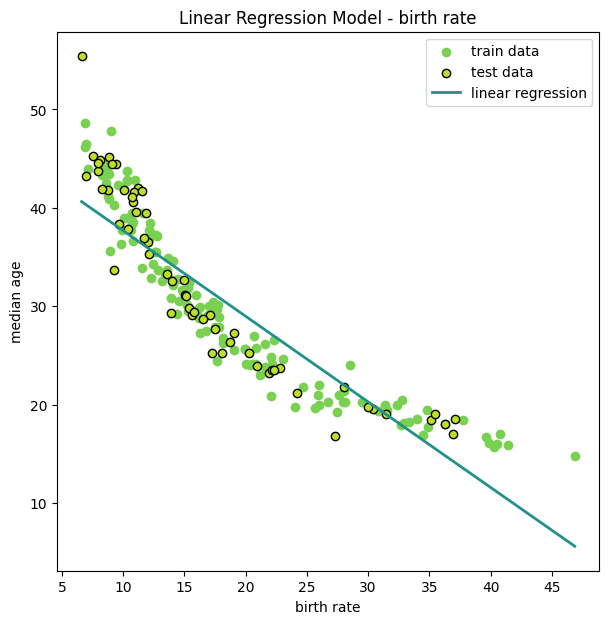

In [38]:
cmap = colormaps['viridis']

plt.figure(figsize=(7, 7))
plt.scatter(X_train_one_feature, y_train, color=cmap(0.8), label='train data')
plt.scatter(X_test_one_feature, y_test, edgecolor='black', facecolor=cmap(0.9), label='test data')
x = [df_x.loc[:, feature_name].min(), df_x.loc[:, feature_name].max()]
plt.plot(x, one_feature_lin_reg_model.predict(np.array(x).reshape(-1, 1)), color=cmap(0.5), linewidth=2.0, label='linear regression')
plt.xlabel('birth rate')
plt.ylabel('median age')
plt.title(f'Linear Regression Model - {feature_name}')
_ = plt.legend()

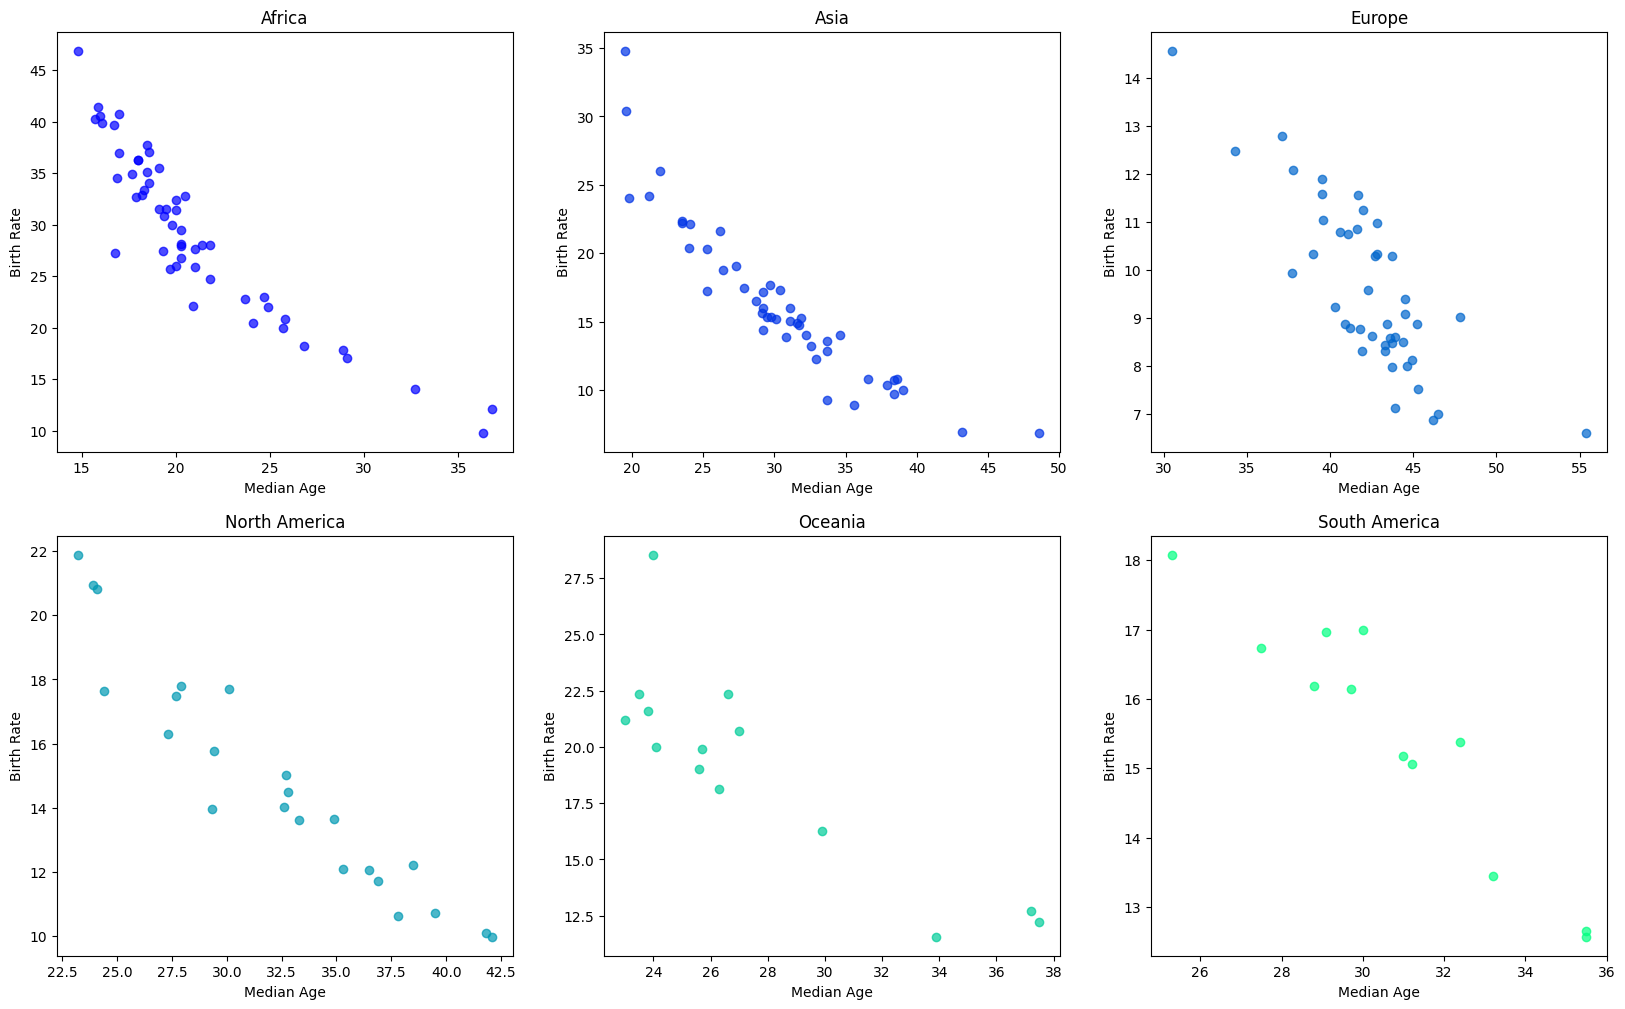

In [39]:
my_plt.plot_by_continent(median_age, country_metrics['birth rate'], 
                         country_metrics['continent'], 
                         'Median Age', 'Birth Rate')

#### Linear regression using all features



Next, we'll fit the same linear regression, but using all features. 

In [40]:
all_features_lin_reg = LinearRegression()
all_features_lin_reg.fit(X_train_prepared, y_train)

LinearRegression()

In [41]:
print(all_features_lin_reg.coef_)
print(all_features_lin_reg.intercept_)

[ 4.73114932e-02 -4.11590441e-01  5.01650622e-01  1.18505527e+00
  2.33235027e-02  4.55189518e-02  2.90302062e-05 -1.60159873e-02
  5.73741241e-03 -1.21458232e-02  1.61184660e-01  7.37111003e-01
  2.87750202e-01  1.87578315e-01 -3.65084912e-01 -1.00853927e+00]
-8.980151164242187


In [42]:
all_features_lin_reg.score(X_test_prepared, y_test)

0.9739778146659874

In [43]:
y_pred = all_features_lin_reg.predict(X_test_prepared)
print("Test MSE: ", mean_squared_error(y_pred, y_test))

Test MSE:  2.3612377035849934


In [44]:
results_df = pd.DataFrame(data=all_features_lin_reg.coef_.reshape(-1, 1), 
                          index=attributes, 
                          columns=['coef_value'])

results_df

,coef_value
alcohol consumption per capita,0.047311
birth rate,-0.411590
life expectancy,0.501651
death rate,1.185055
services occupation ratio,0.023324
health expenditures,0.045519
gdp per capita,0.000029
literacy total,-0.016016
school life expectancy,0.005737
population below poverty,-0.012146


#### Polynomial Regression with different degrees

Now, we'll try to fit models with higher degrees to capture non-linear relationships in data. 

In [45]:
from sklearn.preprocessing import PolynomialFeatures

class PolyRegression:

    def __init__(self, degree):
        self.degrees = degree 
        self.poly_pipeline = make_pipeline(
            SimpleImputer(missing_values=np.nan, strategy='mean'),
            PolynomialFeatures(degree=degree, include_bias=False),
            StandardScaler())
        self.poly_reg = None  

    def fit(self, X, y):
        self.poly_reg = LinearRegression()
        X_transformed = self.poly_pipeline.fit_transform(X)
        self.poly_reg.fit(X_transformed, y)
        self.coef_ = self.poly_reg.coef_
        self.intercept_ = self.poly_reg.intercept_
        
    def predict(self, X):
        X_transformed = self.poly_pipeline.transform(X)
        return self.poly_reg.predict(X_transformed)
    
    def score(self, X, y):
        X_transformed = self.poly_pipeline.transform(X)
        return self.poly_reg.score(X_transformed, y)

We'll try to fit polynomial regression to 
1. Birth rate metric
2. All metrics 

In [46]:
degrees = np.arange(2, 6)


for feature_set in [[feature_index], np.arange(len(attributes))]:
    
    print("Feature set = ", attributes[feature_set])

    X_train_f = X_train_prepared[:, feature_set].reshape(-1, len(feature_set))
    X_test_f = X_test_prepared[:, feature_set].reshape(-1, len(feature_set))

    for degree in degrees:
        print(f'Fitting regression of degree = {degree}')
        
        poly_model = PolyRegression(degree)
        poly_model.fit(X_train_f, y_train)

        print(f'Score = {poly_model.score(X_test_f, y_test)}')
        y_pred = poly_model.predict(X_test_f)
        print(f'Test MSE = {mean_squared_error(y_pred, y_test)}')
        y_pred_train = poly_model.predict(X_train_f)
        print(f'Train MSE = {mean_squared_error(y_pred_train, y_train)}')

Feature set =  ['birth rate']
Fitting regression of degree = 2
Score = 0.9303377175900213
Test MSE = 6.321114296624036
Train MSE = 3.7570432440312658
Fitting regression of degree = 3
Score = 0.941345395314973
Test MSE = 5.322284131538103
Train MSE = 2.9826367682226964
Fitting regression of degree = 4
Score = 0.9414333943436125
Test MSE = 5.314299151735848
Train MSE = 2.9811081506241752
Fitting regression of degree = 5
Score = 0.9416343312868443
Test MSE = 5.296066252372789
Train MSE = 2.92260592360111
Feature set =  ['alcohol consumption per capita' 'birth rate' 'life expectancy'
 'death rate' 'services occupation ratio' 'health expenditures'
 'gdp per capita' 'literacy total' 'school life expectancy'
 'population below poverty' 'Africa' 'Asia' 'Europe' 'North America'
 'Oceania' 'South America']
Fitting regression of degree = 2
Score = 0.3316978080611761
Test MSE = 60.641345557241735
Train MSE = 0.0998974720211336
Fitting regression of degree = 3
Score = 0.9390939444436929
Test MSE = 

We can see that for the 'birth rate' we get an improvement over the linear model, but it's worth only for the 2/3 degree. 
For the whole set of metrics the model gets overfit - the training error is small compared to the testing error

#### SVR with different parameter sets

We will also try support vector regression with different parameter sets. 

In [47]:
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import GridSearchCV

num_pipeline = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'),
    StandardScaler()
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

X_train_prepared = preprocessing.fit_transform(df_X_train)
X_test_prepared = preprocessing.transform(df_X_test)

tuned_params = [{'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10, 100]},
    {'C': [0.01, 0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.01], 
     'kernel': ['rbf', 'poly'], 'degree': [2, 3, 5]      # degree is only for polynomial
    }]

grid_search = GridSearchCV(SVR(), tuned_params, scoring='neg_mean_squared_error',
                           verbose=3)

grid_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 95 candidates, totalling 475 fits
[CV 1/5] END ...........C=0.01, kernel=linear;, score=-21.953 total time=   0.0s
[CV 2/5] END ...........C=0.01, kernel=linear;, score=-35.228 total time=   0.0s
[CV 3/5] END ...........C=0.01, kernel=linear;, score=-30.054 total time=   0.0s
[CV 4/5] END ...........C=0.01, kernel=linear;, score=-38.690 total time=   0.0s
[CV 5/5] END ...........C=0.01, kernel=linear;, score=-23.434 total time=   0.0s
[CV 1/5] END .............C=0.1, kernel=linear;, score=-3.349 total time=   0.0s
[CV 2/5] END .............C=0.1, kernel=linear;, score=-2.909 total time=   0.0s
[CV 3/5] END .............C=0.1, kernel=linear;, score=-5.203 total time=   0.0s
[CV 4/5] END .............C=0.1, kernel=linear;, score=-4.544 total time=   0.0s
[CV 5/5] END .............C=0.1, kernel=linear;, score=-5.966 total time=   0.0s
[CV 1/5] END ...............C=1, kernel=linear;, score=-3.104 total time=   0.0s
[CV 2/5] END ...............C=1, kernel=linear;

GridSearchCV(estimator=SVR(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'degree': [2, 3, 5],
                          'gamma': [0.0001, 0.001, 0.01],
                          'kernel': ['rbf', 'poly']}],
             scoring='neg_mean_squared_error', verbose=3)

In [48]:
svr = grid_search.best_estimator_
svr

SVR(C=100, degree=2, gamma=0.01)

In [49]:
svr.score(X_test_prepared, y_test)

0.9721341182819611

In [50]:
y_pred = svr.predict(X_test_prepared)
mean_squared_error(y_pred, y_test)

2.5285336228188124

The result did not improve over the linear regression, and the model has higher computational complexity.

#### Regularized Linear Regression

Now we'll fit linear regression with lasso regularization. This regularization tends to make unimportant coefficients close to 0, so it generates sparse model.

In [51]:
from sklearn.linear_model import Lasso 

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_prepared, y_train)

Lasso(alpha=0.1)

In [52]:
lasso_reg.score(X_test_prepared, y_test)

0.9731574180774446

In [53]:
y_pred = lasso_reg.predict(X_test_prepared)
mean_squared_error(y_pred, y_test)

2.4356800047174705

In [54]:
lasso_reg.coef_

array([ 0.01051085, -3.83932623,  3.21107458,  3.22123815,  0.2937403 ,
        0.02869521,  0.86831888, -0.        ,  0.        , -0.14838138,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        ])

In [55]:
nonzero_coef_indx = np.flatnonzero(lasso_reg.coef_ > 0)
np.array(attributes)[nonzero_coef_indx]

array(['alcohol consumption per capita', 'life expectancy', 'death rate',
       'services occupation ratio', 'health expenditures',
       'gdp per capita'], dtype='<U30')

In [56]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X_train_prepared, y_train)

ElasticNet(alpha=0.1)

In [57]:
elastic_net.score(X_test_prepared, y_test)

0.9697653052887255

In [58]:
elastic_net.coef_

array([ 0.32975195, -3.58362065,  2.81943263,  2.8360152 ,  0.41517395,
        0.17558365,  0.87765423,  0.        ,  0.02389352, -0.34325748,
       -0.07395122,  0.34640792,  0.38867144,  0.        , -0.        ,
       -0.19579069])

#### Conclusions